# Dependencies

In [52]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [53]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [54]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [55]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
cv2.setRNGSeed(seed)

# Load data

In [56]:
PATH_KAGGLE_DS = "kaggle_dataset"
dataset_df = pd.read_csv(os.path.join("kaggle_dataset", "train.csv"))
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (94477, 4)


In [57]:
dataset_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [58]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    path, sequence_id, sign = dataset_df.sample(n=1).iloc[0][['path', 'sequence_id', 'sign']]
    print(f"sequence_id: {sequence_id}, path: {path}, sign: {sign}")
    
    # Fetch data from parquet file (This dataset stores each landmark in a separate row)
    sample_sequence_df_wrong_format = pq.read_table(f"kaggle_dataset/{path}",).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df_wrong_format.shape))
    
    return sample_sequence_df_wrong_format

In [59]:
random_sequence()

sequence_id: 3311214787, path: train_landmark_files/28656/3311214787.parquet, sign: sticky
Full sequence dataset shape is (11403, 7)


,frame,row_id,type,landmark_index,x,y,z
0,22,22-face-0,face,0,0.555303,0.441405,-0.058642
1,22,22-face-1,face,1,0.551702,0.403915,-0.079649
2,22,22-face-2,face,2,0.553267,0.418683,-0.048917
3,22,22-face-3,face,3,0.539900,0.376674,-0.048386
4,22,22-face-4,face,4,0.551267,0.393446,-0.081520
...,...,...,...,...,...,...,...
11398,42,42-right_hand-16,right_hand,16,0.140721,0.564421,-0.289092
11399,42,42-right_hand-17,right_hand,17,0.033898,0.680667,-0.169942
11400,42,42-right_hand-18,right_hand,18,-0.005285,0.635009,-0.223523
11401,42,42-right_hand-19,right_hand,19,-0.027873,0.605609,-0.251051


In [60]:
NUM_COORDS_FRAME = 543

def gen_column_names(prefix: str, name: str, count: int):
    col_names = []
    for i in range(0, count+1):
        col_names.append(f"{prefix}_{name}_{i}")
    return col_names

columns = list(chain(
    gen_column_names("x", "face", 467),
    gen_column_names("x", "left_hand", 20),
    gen_column_names("x", "pose", 32),
    gen_column_names("x", "right_hand", 20),
    gen_column_names("y", "face", 467),
    gen_column_names("y", "left_hand", 20),
    gen_column_names("y", "pose", 32),
    gen_column_names("y", "right_hand", 20),
    gen_column_names("z", "face", 467),
    gen_column_names("z", "left_hand", 20),
    gen_column_names("z", "pose", 32),
    gen_column_names("z", "right_hand", 20),
))

# Transform the data frame to be the same format as the fingerspelling dataset (1 row for each frame)
def transform_df(df):
    x = df.x
    y = df.y
    z = df.z

    num_frames = len(df) // NUM_COORDS_FRAME
    x = x.values.reshape(num_frames, NUM_COORDS_FRAME)
    y = y.values.reshape(num_frames, NUM_COORDS_FRAME)
    z = z.values.reshape(num_frames, NUM_COORDS_FRAME)

    data = np.concatenate((x, y, z), axis=1)
        
    return pd.DataFrame(data, columns=columns)

In [61]:
%%time
transform_df(random_sequence()).head()

sequence_id: 3794944343, path: train_landmark_files/18796/3794944343.parquet, sign: flower
Full sequence dataset shape is (7602, 7)
CPU times: total: 0 ns
Wall time: 40.4 ms


,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,x_face_9,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
0,0.414046,0.417044,0.416621,0.406389,0.417150,0.417156,0.417042,0.329735,0.416771,0.416652,...,-0.004796,-0.013283,-0.014259,-0.021899,-0.020700,-0.020092,-0.050143,-0.048387,-0.039505,-0.034073
1,0.413669,0.416738,0.416197,0.406099,0.416840,0.416735,0.416251,0.327502,0.415819,0.415617,...,-0.017841,-0.026470,-0.012762,-0.024704,-0.028798,-0.031371,-0.033180,-0.040882,-0.038660,-0.036118
2,0.414238,0.417825,0.417242,0.407150,0.417915,0.417828,0.417401,0.327090,0.417002,0.416816,...,-0.024439,-0.032511,-0.018228,-0.031516,-0.033546,-0.034038,-0.040623,-0.048430,-0.044554,-0.040571
3,0.416779,0.419245,0.418791,0.408553,0.419346,0.419278,0.418851,0.326109,0.418420,0.418291,...,-0.019481,-0.027061,-0.012444,-0.024377,-0.026559,-0.027218,-0.030909,-0.038164,-0.035074,-0.031270
4,0.424905,0.422245,0.421644,0.411585,0.422397,0.422267,0.421531,0.328001,0.421089,0.421048,...,0.002727,-0.003940,-0.010254,-0.014915,-0.014170,-0.014529,-0.036247,-0.037695,-0.032479,-0.028593


# Animation preview

In [62]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [63]:
video = produce_video_from_seq(transform_df(random_sequence()))
create_animation(video)

sequence_id: 2232250892, path: train_landmark_files/37055/2232250892.parquet, sign: moon
Full sequence dataset shape is (9774, 7)


# Statistics

In [66]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.savefig('datasetstat.png', dpi=300)  # High resolution
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50,75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

  0%|          | 0/3000 [00:00<?, ?it/s]

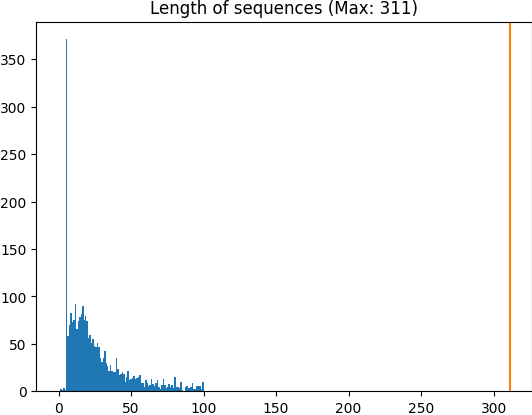

25th percentile: 12.0
50th percentile: 21.0
75th percentile: 43.0
80th percentile: 52.0
90th percentile: 95.0


In [67]:
seq_lengths = []

for file_path in tqdm(dataset_df.sample(n=3000).path):
    count = pq.read_table("kaggle_dataset/" + file_path, columns=['frame']).num_rows
    seq_lengths.append(count // NUM_COORDS_FRAME)

lengths_hist(seq_lengths, "Length of sequences", 100)
calc_percentiles(seq_lengths)

# Save to TFRecords

In [14]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
FPOSE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
POSE = LPOSE + RPOSE + FPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
FPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in FPOSE]

MID_POINT_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) == 1]

In [15]:
def save_tfrecords_to(folder: str):
    for part_id, group_df in tqdm(dataset_df.groupby(by="participant_id")):
        # Save each participant's data into separate files
        tf_file = f"{folder}/{part_id}.tfrecord"
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            for file_path, sign in tqdm(zip(group_df.path, group_df.sign)):
                pq_file = pq.read_table(f"kaggle_dataset/{file_path}",columns=["x", "y", "z"])

                df_original_format = pq_file.to_pandas()
                formatted_df = transform_df(df_original_format)
                frames = formatted_df.values

                features = {formatted_df.columns[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(formatted_df.columns))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(sign, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

In [18]:
PATH_TFRECORD_DS = os.path.join(PATH_KAGGLE_DS, "train_tfrecords_all_coords")
if not os.path.isdir(PATH_TFRECORD_DS):
    os.mkdir(PATH_TFRECORD_DS)
    save_tfrecords_to(PATH_TFRECORD_DS)

    # Also save FEATURE_COLUMNS as it will be necessary during deserializing
    json_str = json.dumps(FEATURE_COLUMNS)
    with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'w') as f:
        f.write(json_str)
else:
    print(f"Warning: Tfrecords already exist! Delete the {PATH_TFRECORD_DS} folder to regenerate them!")

# Fetch from TFRecords

In [16]:
PATH_KAGGLE_DS = "kaggle_dataset"
dataset_df = pd.read_csv(os.path.join(PATH_KAGGLE_DS, "train.csv"))
PATH_TFRECORD_DS = os.path.join(PATH_KAGGLE_DS, "train_tfrecords_all_coords")
tf_records = dataset_df.participant_id.map(lambda x: os.path.join(PATH_TFRECORD_DS, f"{x}.tfrecord")).unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 21 TFRecord files.


In [20]:
with open(os.path.join(PATH_TFRECORD_DS, "feature_columns.json"), 'r') as f:
    json_str = f.read()
FEATURE_COLUMNS = json.loads(json_str)
FEATURE_COLUMNS[:10]

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9']

In [23]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [24]:
sorted_signs = sorted(set(dataset_df.sign))
sign_to_num = {sign : i for i, sign in enumerate(sorted_signs)}
num_to_sign = {i : sign for sign, i in sign_to_num.items()}

In [25]:
MAX_FRAME_LEN = 256
FEATURE_LEN = len(FEATURE_COLUMNS)//3
CHANNELS = 6*FEATURE_LEN

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))
   
def preprocess_landmarks(inp):
    x = inp[:, 0*FEATURE_LEN: 1*FEATURE_LEN]
    y = inp[:, 1*FEATURE_LEN : 2*FEATURE_LEN]
    z = inp[:, 2*FEATURE_LEN : 3*FEATURE_LEN]
    x = tf.concat([x[..., tf.newaxis], y[..., tf.newaxis], z[..., tf.newaxis]], axis=-1)
    # x.shape == (T, P, C) or (N, T, P, C)
    # N: Batch size
    # T: Sequence length
    # P: Number of points (or landmarks)
    # C: Number of channels (features) per point
    
    if tf.rank(x) == 3:
        x = x[None,...]
    # x.shape == (N, T, P, C)
    
    # Mean of midpoints through timesteps
    mean = tf_nan_mean(tf.gather(x, [MID_POINT_IDX[0]], axis=2), axis=[1,2], keepdims=True)
    mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
    # x.shape == (N, 1, 1, C)
    
    # Filtering for relevant points goes here
    # I only saved the relevant ones by chance so experiment with other combinations
    
    std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
    # std.shape == (N, 1, 1, C)
    
    x = (x - mean)/std
    # x.shape == (N, T, P, C)
    
    if MAX_FRAME_LEN is not None:
        x = x[:,:MAX_FRAME_LEN]
    seq_length = tf.shape(x)[1]
    x = x[...,:2]
    # x.shape == (N, T, P, 2)

    # Calc differences between consequtive frames and with skipping 1 in between
    dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))
    # dx.shape == dx2.shape == (N, T, P, 2)
    
    x = tf.concat([
        tf.reshape(x, (-1,seq_length,2*FEATURE_LEN)),
        tf.reshape(dx, (-1,seq_length,2*FEATURE_LEN)),
        tf.reshape(dx2, (-1,seq_length,2*FEATURE_LEN)),
    ], axis = -1)
    # x.shape == (N, T, 6*FEATURE_LEN) where T <= MAX_FRAME_LEN
    
    # Replace NaN values with zeros
    x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
    
    return x[0]

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(sign_to_num.keys()),
        values=list(sign_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

def preprocess_phrase(phrase):
    return table.lookup(phrase)

def preprocess(landmarks, phrase):
    return preprocess_landmarks(landmarks), preprocess_phrase(phrase)

In [26]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

PAD = -100.
NUM_CLASSES = len(sign_to_num)

def get_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False, cache=False):
    ds = tf.data.TFRecordDataset(tf_records)
    ds = ds.map(decode_fn, tf.data.AUTOTUNE)
    ds = ds.map(preprocess, tf.data.AUTOTUNE)
    
    if repeat: 
        ds = ds.repeat()
    
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
        
    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=(PAD, -1), padded_shapes=([MAX_FRAME_LEN, CHANNELS],[]), drop_remainder=drop_remainder)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    if cache:
        ds = ds.cache()
    
    return ds

train_ds = get_dataset(tf_records[:train_len], batch_size=batch_size)
valid_ds = get_dataset(tf_records[train_len:], batch_size=batch_size)

In [27]:
train_iterator = iter(train_ds)

print("Training Data:")
landmarks, phrase = next(train_iterator)
lm_shape = landmarks.shape[2]

print("Landmarks:")
print(type(landmarks))
print(landmarks.shape)
print(landmarks.numpy())
print("-" * 40)
print("Phrase:")
print(phrase.shape)
print(phrase)
print("-" * 40)

Training Data:
Landmarks:
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 256, 372)
[[[-8.46946478e-01  7.90750146e-01 -6.50168478e-01 ... -3.84567678e-03
   -1.35350227e-02 -2.71488726e-03]
  [-8.23016584e-01  7.13746965e-01 -6.19235396e-01 ...  7.18310475e-04
   -1.05634928e-02  2.44282186e-03]
  [-8.01483691e-01  6.73875570e-01 -5.74451506e-01 ...  9.53376293e-05
    1.93512440e-03  1.11070275e-03]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-9.77546096e-01  8.21505725e-01 -7.48384178e-01 ...  1.36579275e-02
   -1.77093446e-02  2.47002244e-02]
  [-9.26388502e-01  7.99359977e-01 -6.90003514e-01 ...  3.62835526e-02
   -2.63395160e-02  3.96442413e-02]
  [-8.13614905e-01  7.32428432e-01 -5.767

# Model

In [47]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)
    
# Efficient channel attention
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, kernel_size=11, use_bias=False):
        super().__init__()
        self.supports_masking = True
        
        self.causal_pad = tf.keras.layers.ZeroPadding1D((kernel_size-1, 0))
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(kernel_size, strides=1, padding='valid', use_bias=use_bias)
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.supports_masking = True
        
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        self.conv_block = tf.keras.models.Sequential([
            CausalDWConv1D()
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        self.eca = ECA()
        
    def call(self, x):
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        x = self.eca(x)
        return x

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, len_of_seq, num_layers, d_model, num_heads,
               dff, num_conv_layers, filter_size, dropout_rate=0.1):
        super().__init__()
        self.supports_masking = True
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalLandmarkEmbedding(
            len_of_seq, d_model, num_conv_layers, filter_size)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is landmark sequences with shape: (batch, seq_len, features)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
    
        return x  # Shape `(batch_size, seq_len, d_model)`.
    
class BertTransformer(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_enc_layers, num_conv_layers, filter_size, d_model, num_heads, dff, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        
        self.masking = tf.keras.layers.Masking(mask_value=PAD,input_shape=(MAX_FRAME_LEN,CHANNELS))
        self.encoder = Encoder(len_of_seq=len_lm_seq,
                               num_layers=num_enc_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               num_conv_layers=num_conv_layers,
                               filter_size=filter_size,
                               dropout_rate=dropout_rate)
    
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        masked_inputs = self.masking(inputs)
        encoded_lm_seq = self.encoder(masked_inputs)
        logits = self.final_layer(encoded_lm_seq)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

# This function is important in case the model needs to be loaded only from the saved weights.
# The exact model needs to be recreated, with all parameters matching!
def get_model(d_model):
    bert_transformer = BertTransformer(
        len_lm_seq=MAX_FRAME_LEN,
        num_enc_layers=2,
        num_conv_layers=3,
        filter_size=11,
        d_model=d_model,
        num_heads=4,
        dff=256, 
        target_vocab_size=len(sign_to_num),
        dropout_rate=0.1)

    return bert_transformer

D_MODEL = CHANNELS # embedding size
model = get_model(D_MODEL)

In [36]:
# # Efficient channel attention
# class ECA(tf.keras.layers.Layer):
#     def __init__(self, kernel_size=5):
#         super().__init__()
#         self.supports_masking = True
#         self.kernel_size = kernel_size
#         self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

#     def call(self, inputs, mask=None):
#         nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
#         nn = tf.expand_dims(nn, -1)
#         nn = self.conv(nn)
#         nn = tf.squeeze(nn, -1)
#         nn = tf.nn.sigmoid(nn)
#         nn = nn[:,None,:]
#         return inputs * nn

# class CausalDWConv1D(tf.keras.layers.Layer):
#     def __init__(self, kernel_size, use_bias=False):
#         super().__init__()
#         self.supports_masking = True
        
#         self.causal_pad = tf.keras.layers.ZeroPadding1D((kernel_size-1, 0))
#         self.dw_conv = tf.keras.layers.DepthwiseConv1D(kernel_size, strides=1, padding='valid', use_bias=use_bias)
        
#     def call(self, inputs):
#         x = self.causal_pad(inputs)
#         x = self.dw_conv(x)
#         return x

# # No dropout noise_shape
# def Conv1DBlock(channel_size,
#           kernel_size,
#           dilation_rate=1,
#           drop_rate=0.0,
#           expand_ratio=1,
#           se_ratio=0.25,
#           activation='swish',
#           name=None):
#     '''
#     efficient conv1d block, @hoyso48
#     '''
#     if name is None:
#         name = str(tf.keras.backend.get_uid("mbblock"))
#     # Expansion phase
#     def apply(inputs):
#         channels_in = tf.keras.backend.int_shape(inputs)[-1]
#         channels_expand = channels_in * expand_ratio

#         skip = inputs
        
#         x = tf.keras.layers.Dense(
#             channels_expand,
#             use_bias=True,
#             activation=activation,
#             name=name + '_expand_conv')(inputs)

#         # Depthwise Convolution
#         x = CausalDWConv1D(kernel_size,
#             use_bias=False)(x)

#         x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

#         x  = ECA()(x)

#         x = tf.keras.layers.Dense(
#             channel_size,
#             use_bias=True,
#             name=name + '_project_conv')(x)
        
#         if drop_rate > 0:
#             x = tf.keras.layers.Dropout(drop_rate, name=name + '_drop')(x)

#         if (channels_in == channel_size):
#             x = tf.keras.layers.add([x, skip], name=name + '_add')
#         return x

#     return apply

# # same as original (why not the built-in?)
# class MultiHeadSelfAttention(tf.keras.layers.Layer):
#     def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
#         super().__init__(**kwargs)
#         self.dim = dim
#         self.scale = self.dim ** -0.5
#         self.num_heads = num_heads
#         self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
#         self.drop1 = tf.keras.layers.Dropout(dropout)
#         self.proj = tf.keras.layers.Dense(dim, use_bias=False)
#         self.supports_masking = True

#     def call(self, inputs, mask=None):
#         qkv = self.qkv(inputs)
#         qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
#         q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

#         attn = tf.matmul(q, k, transpose_b=True) * self.scale

#         if mask is not None:
#             mask = mask[:, None, None, :]

#         attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
#         attn = self.drop1(attn)

#         x = attn @ v
#         x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
#         x = self.proj(x)
#         return x

# def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
#     def apply(inputs):
#         x = inputs
#         x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
#         x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
#         x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
#         x = tf.keras.layers.Add()([inputs, x])
#         attn_out = x

#         x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
#         x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
#         x = tf.keras.layers.Dense(dim, use_bias=False)(x)
#         x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
#         x = tf.keras.layers.Add()([attn_out, x])
#         return x
#     return apply

# # small dropout
# def get_model(dim):
#     ksize = 17

#     inp = tf.keras.Input((MAX_FRAME_LEN,CHANNELS))
#     x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(MAX_FRAME_LEN,CHANNELS))(inp)
#     x = tf.keras.layers.Dense(dim, use_bias=False)(x)
#     x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
    
#     x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
#     x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
#     x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
#     x = Conv1DBlock(dim, ksize, drop_rate=0.2)(x)
#     x = TransformerBlock(dim, expand=2)(x)

#     x = tf.keras.layers.Dense(dim*2, activation=None)(x)
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(NUM_CLASSES)(x)
#     return tf.keras.Model(inp, x)

In [39]:
lm_seq, sing_idx = next(iter(train_ds))

In [48]:
y = model(lm_seq)
model.summary()

Model: "bert_transformer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         multiple                  0         
                                                                 
 encoder_8 (Encoder)         multiple                  4835401   
                                                                 
 dense_34 (Dense)            multiple                  93250     
                                                                 
Total params: 4928651 (18.80 MB)
Trainable params: 4928651 (18.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"])

In [50]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='first_run_till_its_dead.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [51]:
%%time
model.fit(train_ds,
          validation_data=valid_ds,
          epochs=50,
          #callbacks=[checkpoint_callback],
          verbose = 2)

Epoch 1/50


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InvalidArgumentError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\errors_impl.py(284): __init__
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\execute.py(60): quick_execute
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\context.py(1479): call_function
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(252): __call__
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py(217): flat_call
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\concrete_function.py(1264): _call_flat
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py(139): call_function
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(904): _call
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py(831): __call__
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\traceback_utils.py(150): error_handler
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py(1783): fit
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py(65): error_handler
  <timed eval>(1): <module>
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\execution.py(1332): time
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(2493): run_cell_magic
  C:\Users\MDancso\AppData\Local\Temp\ipykernel_7312\4228347556.py(1): <module>
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(3526): run_code
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(3466): run_ast_nodes
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(3284): run_cell_async
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py(129): _pseudo_sync_runner
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(3079): _run_cell
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py(3024): run_cell
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py(546): run_cell
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py(422): do_execute
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py(740): execute_request
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py(412): dispatch_shell
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py(505): process_one
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py(516): dispatch_queue
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py(80): _run
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(1905): _run_once
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(601): run_forever
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py(195): start
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py(736): start
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py(1046): launch_instance
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py(17): <module>
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\runpy.py(87): _run_code
  C:\Users\MDancso\AppData\Local\Programs\Python\Python39\lib\runpy.py(197): _run_module_as_main
